# Let's go

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import pysixtracklib as pyst
from pysixtracklib import stcommon as st

In [3]:
from scipy.constants import e, m_p, c, epsilon_0

In [4]:
import sys
sys.path = ["/home/HPC/oeftiger/PyHEADTAIL_py3/python3/PyHEADTAIL/", 
            "/home/HPC/oeftiger/PyHEADTAIL_py3/"] + sys.path

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5





In [5]:
n_macroparticles = int(1e4)
n_turns = 1024

Qs = 1e-3
bunch_length = 10e-9 # in [s]

p0c = 100e6 # in eV

circumference = 10

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)

sigma_z = beta * c * bunch_length / 4. # in [m]

eta = -gamma**-2
# Qs = np.sqrt(e * rf_voltage * 1 * -eta / (2 * np.pi * p0 * beta * c))
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (e * 1 * -eta)
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

# beta_z = sigma_z / sigma_dp
sigma_dp = sigma_z / beta_z
epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [6]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.07.22 18:34:13      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [7]:
madx.input('''
kqd := -0.1;
kqf := 0.1;
v := 0;

qd: multipole, knl := {0, kqd/2.};
qf: multipole, knl := {0, kqf};
rf: rfcavity, volt := v, harmon = 1, lag = 0; //, lag = 0.5;

fodo: sequence, l = ''' + str(circumference) + ''';
qd, at = 0;
qf, at = 5;
rf, at = 5;
qd, at = 10;
endsequence;
''')

True

In [8]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [9]:
madx.use(sequence='fodo')

In [10]:
madx.input('v := {}'.format(rf_voltage * 1e-6)) # MV

++++++ info: v redefined


True

In [11]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0    9.758753786e-06        320.1126374 

                q1                dq1            betxmax              dxmax 
     0.08043062326       -0.775499787        25.81988897                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0      0.08043062326 

               dq2            betymax              dymax              dyrms 
      -0.775499787        25.81988897                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

# on the GPU

In [12]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [13]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [14]:
elements.BeamMonitor(num_stores=n_turns);

In [15]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

In [16]:
pyst_beam.zeta[:] = np.random.uniform(-3, 3, size=n_macroparticles)

In [23]:
elements.get_elements()[-1]

<BeamMonitor at 400
  num_stores:1024
  start:0
  skip:1
  out_address:140581216317584
  max_particle_id:9999
  min_particle_id:0
  is_rolling:0
  is_turn_ordered:1
>

In [18]:
trackjob.track_until(n_turns)

In [19]:
trackjob.collect()

In [20]:
z = trackjob.output.particles[0].zeta
dp = trackjob.output.particles[0].delta

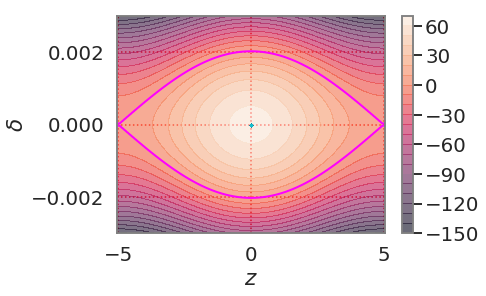

In [21]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])

plz = np.linspace(*rfb.interval, num=100)
pldp = np.linspace(-0.003, 0.003, num=100)
ZZ, DPP = np.meshgrid(plz, pldp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
for i in range(100):
    plt.scatter(z[i::n_macroparticles], dp[i::n_macroparticles], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

# on the CPU

In [24]:
del pyst_beam, elements, trackjob

In [25]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [26]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [27]:
elements.BeamMonitor(num_stores=n_turns);

In [28]:
trackjob = pyst.TrackJob(elements, pyst_beam)

In [29]:
pyst_beam.zeta[:] = np.random.uniform(-3, 3, size=n_macroparticles)

In [30]:
elements.get_elements()[-1]

<BeamMonitor at 400
  num_stores:1024
  start:0
  skip:1
  out_address:140577156231312
  max_particle_id:9999
  min_particle_id:0
  is_rolling:0
  is_turn_ordered:1
>

In [32]:
trackjob.track(n_turns)

0

In [33]:
trackjob.collect()

In [34]:
z = trackjob.output.particles[0].zeta
dp = trackjob.output.particles[0].delta

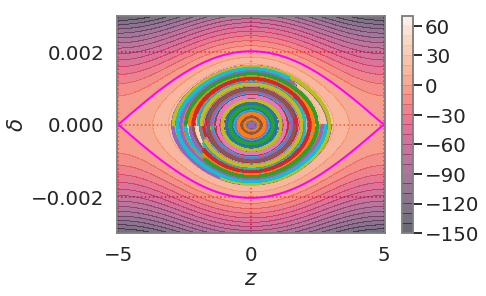

In [35]:
rfb = RFBucket(circumference, gamma, m_p, e, [0], 0, [1], [rf_voltage], [np.pi])

plz = np.linspace(*rfb.interval, num=100)
pldp = np.linspace(-0.003, 0.003, num=100)
ZZ, DPP = np.meshgrid(plz, pldp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
for i in range(100):
    plt.scatter(z[i::n_macroparticles], dp[i::n_macroparticles], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

# Version of SixTrackLib:

In [37]:
!cd /home/HPC/oeftiger/from_martin/sixtracklib/ && git log | head -10

commit ad72d17c209556b6a8d72202e89327c5e8b4e18f
Author: Martin Schwinzerl <martin.schwinzerl@gmail.com>
Date:   Mon Jun 17 21:35:48 2019 +0200

    common: fixes missing cuda incldue directory on track submodule to common
    
    NOTE: This is a temporary workaround
    TODO: Properly fix this without pulling in cuda as an dependency

commit 7760163971fd21ff25cbd977df6cda1ee8be14cf
